<a href="https://colab.research.google.com/github/TOM-BOHN/MsDS-marketing-network-analysis/blob/main/marketing_network_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Marketing Network Analysis
**Thomas Bohn**   --   **2023-10-11**

A report focused on Network Analysis using [nltk](https://www.nltk.org/) to process text from twitter and [NetworkX](https://networkx.org/) to analyze the network. The network analysis will focus 2 types of networks, a user relationship network, and a semantic network. The user relationship network will focus on understanding users central to the brands and user influential in the product category, focusing on the analysis of twitter mention as a graph data structure. The semantic network anlysis will focus on better understanding the conversation around each brand, what makes the brand unique, and what makes each brand different.

--  [Main Report](https://github.com/TOM-BOHN/MsDS-marketing-network-analysis/blob/main/marketing_network_analysis.ipynb)  --  [Github Repo](https://github.com/TOM-BOHN/MsDS-marketing-network-analysis)  --  [Presentation Slides](https://docs.google.com/presentation/d/19MQawtFQv2sK_VZn0lhSueZuIDgawSz26zmG6LZdNik/edit?usp=sharing)  --  [Presentation Video](https://drive.google.com/file/d/1lKyO63ezfLaTzwn4Df_4qph36Zh4RvOY/view?usp=sharing) --

# 1.&nbsp;Introduction

**Context**
Network Analysis is applicable to any dataset where the relationships between elements are importnant. One source of rich network (or graph) data is through Twitter or other social networks, where people post, share, and mentions other.In the case of network analysis, we can use tweets that are created and mention brands of interest to understand the conversation around a specific topic or category.

**Background**
This notebook focuses on an analysis of how consumers talk about three competing brands: **Nike**, **Adidas**, and **Lululemon**. This will take the form of network analysis and semantic network analysis, using a graph data representation of the dataset to look for trends and patterns.

The goal is to understand the chatter around each brand better, what makes each brand unique, and what makes each brand different. Network analysis will also be used to identify users that are most central to the brand and users that are hyper interested in the product category of athletic wear.

**Data Source**
The dataset is sourced from the Twitter API, specifically the [Search Endpoint](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/api-reference/get-search-tweets) to retrieve Tweets that mention the three brands of interest. The following describes the scope of the data:
- Tweets were retrieved over the last 93 days
- About ~150k tweets are included in the dataset
- Tweets are “at Mentions” (@nike, @lululemon, @adidas)
- Tweets were sent from the US and are in English

The raw data sources for the project can be accessed with the following links:
- [Tweet Data](http://128.138.93.164/nikelululemonadidas_tweets.jsonl.gz)

**Overview of Observations**

Twitter API data is utilized in this project. The structure of the [Tweet object model](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet) can be as a data dictionary provided by Twitter as part of the Twitter Developer Platform.

**Objective**
The objective is to build a unsupervize network analysis to explore and analyze the dataset for 3 athletic wear brands: **Nike**, **Adidas**, and **Lululemon**. The analysis wil follow 3 worksteams:
1. **Twitter Mentions Graph** - A valued, directed network graph of Twitter mentions. Will show Twitter users that are most centrally related to the brand (e.g., they regularly mention the brand). This graph will also illustrate who mentions who on Twitter, and in what way those mentions flow. One mention graph will be created with mentions for all three brands.
2. **Semantic Network Graph** - A semantic network analysis graph of words used in Tweets. This graph will reveal what words are most commonly associated with each other, for each brand. One semantic graph will be created, with data for all three brands.
3. **Using the Graph Data for Analysis:** Using the dataset and graphs, analyze specific questions related to the brands to help the brands understand the conversation and who is involved in the conversation.

**Report Overview**
The project will cover 5 key phases:
1. Data Source: Extracting, filtering, and focusing the data on the Nike brand
2. Preprocessing: Extracting Features from Tweets
3. Mention Network: Analysis of @mentions in the Tweet corpus
4. Semantic Network: Analysis of the words used in the Tweet corpus
5. Graph with Pyvis: Analysis of graph data using pyvis
6. Data Analysis and Exploration: Answer specific questions about the graph network datasets

## Import Python Libraries

The following python libraries are used in this notebook.

In [3]:
print('[-] Importing packages...')
# File Connection and File Manipulation
import os
import pickle
import gzip
import json
# Basic Data Science Toolkits
import pandas as pd
import numpy as np
import math
import random
import time
import re
import itertools
import datetime
# Basic Data Vizualization
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
# Text Preprocessing(other)
import string
import nltk

[-] Importing packages...


In [4]:
print('[-] Importing packages...')
try:
  import pyvis
  from pyvis.network import Network
except:
  !pip install pyvis
  import pyvis
  from pyvis.network import Network

[-] Importing packages...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.0 MB/s eta 0:00:00


Using the `punkt`, `stopwords` and `wordnet` datasets from nltk in our analysis. Downloaded here for use in our notebook.

In [5]:
#Download required corpus based data to nltk package
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Set Global Variables

In [6]:
gDEBUG = True

## Verify GPU Runtime

In [7]:
#see the GPU assigned
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [8]:
#See the virtual memory assigned
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('  [.] Your runtime has {:.1f} gigabytes of available RAM'.format(ram_gb))

if ram_gb < 20:
  print('  [.] Not using a high-RAM runtime')
else:
  print('  [.] You are using a high-RAM runtime!')

  [.] Your runtime has 54.8 gigabytes of available RAM
  [.] You are using a high-RAM runtime!


## Mount Google Drive

In [9]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup Directories

In [10]:
#Setup Directories
ROOT_DIR = "/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/3_network_analysis"
DATA_DIR = "%s/data" % ROOT_DIR
EVAL_DIR = "%s/evaluation" % ROOT_DIR
MODEL_DIR = "%s/models" % ROOT_DIR

#Create missing directories, if they don't exist
if not os.path.exists(DATA_DIR):
  # Create a new directory because it does not exist
  os.makedirs(DATA_DIR)
  print("The data directory is created!")
if not os.path.exists(EVAL_DIR):
  # Create a new directory because it does not exist
  os.makedirs(EVAL_DIR)
  print("The evaluation directory is created!")
if not os.path.exists(MODEL_DIR):
  # Create a new directory because it does not exist
  os.makedirs(MODEL_DIR)
  print("The model directory is created!")

# 2.&nbsp;Data Source

Import and process the Twitter data.

## Copy Data From Source

In [ ]:
#Copy Data From Source
#!wget <URL> -P <COLAB PATH>
#source_url = 'http://128.138.93.164/nikelululemonadidas_tweets.jsonl.gz' # true source, need better link
source_url = 'https://docs.google.com/uc?export=download&id=12sq73UTafhP6M8iUuP62yr4uRthFEp_-&confirm=t' # local source, working for testing
dest_path = '%s/nikelululemonadidas_tweets.jsonl.gz' % DATA_DIR
!wget "$source_url" -O "$dest_path"

--2023-10-10 18:30:53--  https://docs.google.com/uc?export=download&id=12sq73UTafhP6M8iUuP62yr4uRthFEp_-&confirm=t
Resolving docs.google.com (docs.google.com)... 142.251.167.100, 142.251.167.101, 142.251.167.138, ...
Connecting to docs.google.com (docs.google.com)|142.251.167.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/q1tu7o7u37oa0sgvgkhf3mb823n146cm/1696962600000/15741694635513001712/*/12sq73UTafhP6M8iUuP62yr4uRthFEp_-?e=download&uuid=4813233d-a485-4496-a70d-399fb5f3e828 [following]
--2023-10-10 18:30:53--  https://doc-0o-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/q1tu7o7u37oa0sgvgkhf3mb823n146cm/1696962600000/15741694635513001712/*/12sq73UTafhP6M8iUuP62yr4uRthFEp_-?e=download&uuid=4813233d-a485-4496-a70d-399fb5f3e828
Resolving doc-0o-58-docs.googleusercontent.com (doc-0o-58-docs.googleusercontent.com)... 172.253.63.1

In [ ]:
#tweet_file_path = '%s/nikelululemonadidas_tweets.jsonl.gz' % DATA_DIR
#!gzip -d "$tweet_file_path"

## Inspect Some of the Data

In [ ]:
LIMIT = 5
tweet_file_path = '%s/nikelululemonadidas_tweets.jsonl' % DATA_DIR

# Inspect LIMIT number of Tweets that mention Nike
with open(tweet_file_path) as data_file:
    for i, line in enumerate(data_file):
        if i >= LIMIT:
            break
        tweet = json.loads(line)
        text = tweet.get("full_text") or tweet.get("text")
        if "nike" in text.lower():
            print('tweet', i,':', text, '\n')

tweet 0 : #ad The Nike Women's Air More Uptempo 96 'White/Opti Yellow' is now available via @footlocker! |$160| #SneakerScouts @Nike https://t.co/5lAq7b2ffU https://t.co/wmjxIcsheP 

tweet 2 : Proof @LaserShip is stealing. I work from home and have a ring doorbell. @wsoctv @Nike @wcnc @wbtv @bbb_us https://t.co/9o3stezjgs 

tweet 3 : RT @pyleaks: *LEAK ALERT*: The next Supreme x @Nike collab for Spring 2022 will feature the Nike Shox Ride 2.
The duo will be dropping 3 co… 

tweet 4 : RT @SneakerScouts: #ad The Space Jam x Nike LeBron 18 Low 'Sylvester vs. Tweety' is now available via @snipes_usa! |$160| #SneakerScouts @K… 



In [ ]:
tweet

{'created_at': 'Fri Oct 01 06:22:08 +0000 2021',
 'id': 1443823529296867300,
 'id_str': '1443823529296867350',
 'full_text': "RT @SneakerScouts: #ad The Space Jam x Nike LeBron 18 Low 'Sylvester vs. Tweety' is now available via @snipes_usa! |$160| #SneakerScouts @K…",
 'truncated': False,
 'display_text_range': [0, 140],
 'entities': {'hashtags': [{'text': 'ad', 'indices': [19, 22]},
   {'text': 'SneakerScouts', 'indices': [122, 136]}],
  'symbols': [],
  'user_mentions': [{'screen_name': 'SneakerScouts',
    'name': '#SneakerScouts',
    'id': 792182745942233100,
    'id_str': '792182745942233089',
    'indices': [3, 17]},
   {'screen_name': 'snipes_usa',
    'name': 'SNIPES_USA',
    'id': 83606701,
    'id_str': '83606701',
    'indices': [102, 113]}],
  'urls': []},
 'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 

# 3.&nbsp;Create a Mention Network

## Load the Corpus of Tweets

In [81]:
## Load the Product Data
##this assigns the filename we're trying to load in to a string variable
tweet_file_path = '%s/nikelululemonadidas_tweets.jsonl' % DATA_DIR
json_file = open(tweet_file_path, 'r')

## Create a List of Unique Users

In [82]:
# Identify unique users in the mention network
unique_users = {}

#iterate through each row in the twitter corpus and extract twitter users
for i, atweet in enumerate(json_file):
    if i % 10000 == 0: # Show a periodic status
      print("%s tweets iterated" % i)
    tweet_json = json.loads(atweet)
    user_who_tweeted = tweet_json['user']['screen_name']
    id_who_tweeted = tweet_json['user']['id']
    follower_count = tweet_json['user']['followers_count']
    if id_who_tweeted in unique_users:
      unique_users[id_who_tweeted]['tweet_count'] += 1
      if unique_users[id_who_tweeted]['followers_count'] == 0:
        unique_users[id_who_tweeted]['followers_count'] = follower_count
    if id_who_tweeted not in unique_users:
      unique_users[id_who_tweeted] = {}
      unique_users[id_who_tweeted]['tweet_count'] = 1
      unique_users[id_who_tweeted]['mention_count'] = 0
      unique_users[id_who_tweeted]['id'] = id_who_tweeted
      unique_users[id_who_tweeted]['followers_count'] = follower_count
      unique_users[id_who_tweeted]['screen_name'] = user_who_tweeted.lower()
    #add in the mentioned users as well
    users_mentioned = tweet_json['entities']['user_mentions']
    #if the tweet netions other users in the tweet
    if len(users_mentioned) > 0:
      # iterate through each mention in the tweet
      for user_mentioned in users_mentioned:
        #extract details about user
        screen_name_mentioned = user_mentioned['screen_name']
        id_mentioned = user_mentioned['id']
        #if in the list, increase the mention count
        if id_mentioned in unique_users:
          unique_users[id_mentioned]['mention_count'] += 1
        #extract details about the metioned users in the tweet
        if id_mentioned not in unique_users:
          unique_users[id_mentioned] = {}
          unique_users[id_mentioned]['tweet_count'] = 0
          unique_users[id_mentioned]['mention_count'] = 1
          unique_users[id_mentioned]['id'] = id_mentioned
          unique_users[id_mentioned]['followers_count'] = 0
          unique_users[id_mentioned]['screen_name'] = screen_name_mentioned.lower()

print(f"{i} total Tweets processed")

0 tweets iterated
10000 tweets iterated
20000 tweets iterated
30000 tweets iterated
40000 tweets iterated
50000 tweets iterated
60000 tweets iterated
70000 tweets iterated
80000 tweets iterated
90000 tweets iterated
100000 tweets iterated
110000 tweets iterated
120000 tweets iterated
130000 tweets iterated
140000 tweets iterated
150000 tweets iterated
160000 tweets iterated
170000 tweets iterated
175077 total Tweets processed


In [83]:
#print the number of unique users in the corpus
print('there are', len(unique_users), 'total users in the mention network.')

there are 131663 total users in the mention network.


## Create User Filter List

In [84]:
users_to_include = set()
# if any user has more than 2 tweets
min_tweet_count = 2
# if any user has more than 2500 followers
min_followers_count = 100000
# create a list of brand users
brand_users = ['nike', 'lululemon', 'adidas']

# a set is a unique list
user_count = 0

#iterate through the list of unique users and filter down the list
for auser in unique_users:
  if unique_users[auser]['screen_name'] in brand_users:
      print('id:', auser, '\tscreen_name:', unique_users[auser]['screen_name'])
      user_count += 1
      users_to_include.add(auser)
  elif unique_users[auser]['tweet_count'] >= min_tweet_count:
    if unique_users[auser]['followers_count'] >= min_followers_count:
      user_count += 1
      users_to_include.add(auser)
print(len(users_to_include))

id: 415859364 	screen_name: nike
id: 300114634 	screen_name: adidas
id: 16252784 	screen_name: lululemon
198


In [85]:
#print the number of unique users to include in the graph
print('there are', len(users_to_include), 'users to include in the final mention network.')
pct_of_total = round(len(users_to_include) / len(unique_users),4) * 100
print(f"{pct_of_total}% of the total users are included in the mention network.")

there are 198 users to include in the final mention network.
0.15% of the total users are included in the mention network.


In [86]:
#print the word counts for the major brands
print("Nike:", unique_users[415859364])
print("Adidas:", unique_users[300114634])
print("Lululemon:", unique_users[16252784])

Nike: {'tweet_count': 0, 'mention_count': 120125, 'id': 415859364, 'followers_count': 0, 'screen_name': 'nike'}
Adidas: {'tweet_count': 3, 'mention_count': 36654, 'id': 300114634, 'followers_count': 4082910, 'screen_name': 'adidas'}
Lululemon: {'tweet_count': 0, 'mention_count': 6294, 'id': 16252784, 'followers_count': 0, 'screen_name': 'lululemon'}


##Helper Functions for Analysis

In [87]:
def graph_summary_stats(G, title='Graph Summary'):
  #display a summary of the graph object created
  #nx.info(G)
  # https://networkx.org/documentation/stable/reference/functions.html
  print('----------------------------------------')
  print('#####', title, '#####')
  print('number of nodes:', nx.number_of_nodes(G))
  print('number of edges:', nx.number_of_edges(G))
  print()
  print('nodes:', nx.nodes(G))
  print()
  if G.has_node('adidas'):
    print('neighbors of adidas:', list(nx.all_neighbors(G, 'adidas')))
  if G.has_node('nike'):
    print('neighbors of nike:', list(nx.all_neighbors(G, 'nike')))
  if G.has_node('lululemon'):
   print('neighbors of lululemon:', list(nx.all_neighbors(G, 'lululemon')))
  print('----------------------------------------\n')

In [238]:
#function to plot the graph object and write to png
def plot_graph(G, file_path='temp_file', use_edge_weight=True, plot_size='large'):
  #define node colors
  default_color = 'blue'
  highlight_color = 'red'
  brand_users = ['nike', 'lululemon', 'adidas']
  node_colors = [highlight_color if node in brand_users else default_color for node in G.nodes()]

  #set plot size for drawing
  if plot_size == 'medium-large':
    p_figsize = (150, 150)
    p_font_size = 20
    p_edge_width_scale = 2
    p_node_size = 5000
    p_arrow_size = 50
    p_k = None
  if plot_size == 'medium':
    p_figsize = (25, 25)
    p_font_size = 12
    p_edge_width_scale = 2
    p_node_size = 3000
    p_arrow_size = 50
    p_k = None
  elif plot_size == 'small':
    p_figsize = (50, 50)
    p_font_size = 20
    p_edge_width_scale = 2
    p_node_size = 30000
    p_arrow_size = 100
    p_k = None
  elif plot_size == 'x-small':
    p_figsize = (12, 12)
    p_font_size = 20
    p_edge_width_scale = 2
    p_node_size = 5000
    p_arrow_size = 100
    p_k = None
  else: #plot_size == 'large'
    p_figsize = (300, 300)
    p_font_size = 20
    p_edge_width_scale = 2
    p_node_size = 3000
    p_arrow_size = 100
    p_k = None

  #generate a spring layout for the graph
  positions = nx.spring_layout(G, k=p_k)

  #extract edge weights for drawing
  if use_edge_weight == True:
    p_edge_weights = p_edge_width_scale*[G[u][v]['weight'] for u, v in G.edges()]
  else:
    p_edge_weights = p_edge_width_scale

  #create a figure and adjust the size of the figure
  fig, ax = plt.subplots(1, 1, figsize=p_figsize)
  #draw the graph of the network
  nx.draw_networkx(G, pos=positions, ax=ax, node_color=node_colors,
                   font_color="#FFFFFF", font_size=p_font_size,
                   node_size=p_node_size, width=p_edge_weights,
                   arrows=True, arrowsize=p_arrow_size)
  #save the graph to a file
  print_file_path = '%s/%s.png' % (MODEL_DIR,file_path)
  plt.savefig(print_file_path, format='PNG')
  plt.close('all')

In [89]:
def focus_edges(G, brand_nodes = None, weight_min = None, weight_max = None):
  # Filter based on a list of brand nodes to focus
  if brand_nodes != None:
    # Filter edges based on the weight threshold
    filtered_edges = [(u, v) for u, v in G.edges() if u in brand_nodes or v in brand_nodes]
    # Create a subgraph based on the filtered edges
    G = G.edge_subgraph(filtered_edges)
  # Filter based on weight threshold
  if weight_min != None:
    # Filter edges based on the weight threshold
    filtered_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] >= weight_min]
    # Create a subgraph based on the filtered edges
    G = G.edge_subgraph(filtered_edges)
  if weight_max != None:
    # Filter edges based on the weight threshold
    filtered_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] <= weight_max]
    # Create a subgraph based on the filtered edges
    G = G.edge_subgraph(filtered_edges)
  # Return the filtered subgraph
  return G

## Create a Graph Object

In [90]:
#load the source data
tweet_file_path = '%s/nikelululemonadidas_tweets.jsonl' % DATA_DIR
json_file = open(tweet_file_path, 'r')

In [91]:
#create a blank graph object
MEN_Graph = nx.DiGraph()

In [92]:
# Identify unique users in the mention network
for i, atweet in enumerate(json_file):
    #provide an update on processing progress
    if i % 10000 == 0:
      print("%s tweets iterated" % i)
    #load a line of the twitter corpus
    tweet_json = json.loads(atweet)
    #extract details from the tweet
    user_who_tweeted = tweet_json['user']['screen_name'].lower()
    id_who_tweeted = tweet_json['user']['id']
    follower_count = tweet_json['user']['followers_count']
    #check if the user id is in the list to include
    if id_who_tweeted in users_to_include:
      users = tweet_json['entities']['user_mentions']
      #if the tweet netions other users in the tweet
      if len(users) > 0:
          # iterate through each mention in the tweet
          for auser in users:
              #extract details about the metioned users in the tweet
              screen_name = auser['screen_name'].lower()
              mention_id = auser['id']
              #if the mentioned user is on the list to included
              if mention_id in users_to_include:
                if user_who_tweeted != screen_name:
                  #add an edge to the graph
                  if MEN_Graph.has_edge(user_who_tweeted, screen_name):
                    # If the edge exists, increment its weight
                    MEN_Graph[user_who_tweeted][screen_name]['weight'] += 1
                  else:
                    # If the edge doesn't exist, add it with weight=1
                    MEN_Graph.add_edge(user_who_tweeted, screen_name, weight=1)
print(f"{i} total tweets processed")

0 tweets iterated
10000 tweets iterated
20000 tweets iterated
30000 tweets iterated
40000 tweets iterated
50000 tweets iterated
60000 tweets iterated
70000 tweets iterated
80000 tweets iterated
90000 tweets iterated
100000 tweets iterated
110000 tweets iterated
120000 tweets iterated
130000 tweets iterated
140000 tweets iterated
150000 tweets iterated
160000 tweets iterated
170000 tweets iterated
175077 total tweets processed


In [231]:
graph_summary_stats(G = MEN_Graph)

----------------------------------------
##### Graph Summary #####
number of nodes: 194
number of edges: 339

nodes: ['kiganyi_', 'adidas', 'undefeatedinc', 'uniwatch', 'nike', 'atari_jones', 'adidasoriginals', 'solefed', 'jumpman23', 'bajabiri', 'golfdigest', 'lululemon', 'jonahlupton', 'nikestore', 'jermainedupri', 'finishline', 'wwd', 'hiphopwired', 'xboxwire', 'aarongreenberg', 'xbox', 'xboxp3', 'predsnhl', 'lakings', 'dashiexp', 'fastcompany', 'reignofapril', 'nrarmour', 'sbjsbd', 'barcaacademy', 'khou', 'oakley', 'marshablackburn', 'senrickscott', 'schuh', 'dezeen', 'lebatardshow', 'billiejeanking', 'barrysanders', 'complex', 'brooksrunning', 'adidasrunning', 'wiedenkennedy', 'bottom2thatop', 'candace_parker', 'snkr_twitr', 'katgraham', 'joshog', 'adweek', 'kingjames', 'jamesgunn', 'pomklementieff', 'loyalty360', 'jasonlacanfora', 'kohls', '7newsdc', 'realrclark25', 'adidashoops', 'wnba', 'barondavis', 'metropolismag', 'legiqn', 'fatkiddeals', 'jack_p', 'nyctsubway', 'nikebasketb

In [94]:
#MEN_Graph.edges(data=True)

## Create Subgraphs for Analysis

In [232]:
##### Shared Sets of Node Intersetions #####

# Define key nodes
key_nodes_all = ['nike', 'lululemon', 'adidas']
key_nodes_nl = ['nike', 'lululemon']
key_nodes_na = ['nike', 'adidas']
key_nodes_al = ['adidas', 'lululemon']

# Find neighbors of the key nodes by themselves
neighbors_sets_n = set(nx.all_neighbors(MEN_Graph, 'nike'))
neighbors_sets_a = set(nx.all_neighbors(MEN_Graph, 'adidas'))
neighbors_sets_l = set(nx.all_neighbors(MEN_Graph, 'lululemon'))

# Find neighbors of the key nodes
neighbors_sets_all = [set(nx.all_neighbors(MEN_Graph, node)) for node in key_nodes_all]
neighbors_sets_nl = [set(nx.all_neighbors(MEN_Graph, node)) for node in key_nodes_nl]
neighbors_sets_na = [set(nx.all_neighbors(MEN_Graph, node)) for node in key_nodes_na]
neighbors_sets_al = [set(nx.all_neighbors(MEN_Graph, node)) for node in key_nodes_al]

# Intersect the sets to get nodes connected to all key nodes
common_neighbors_all = set.intersection(*neighbors_sets_all)

# Intersect the sets to get nodes connected to only 2 key nodes

common_neighbors_nl = set.intersection(*neighbors_sets_nl) - common_neighbors_all - set(key_nodes_al)
common_neighbors_na = set.intersection(*neighbors_sets_na) - common_neighbors_all - set(key_nodes_nl)
common_neighbors_al = set.intersection(*neighbors_sets_al) - common_neighbors_all - set(key_nodes_na)

# Get nodes connected to any one of the key nodes but not all of them
union_neighbors = set.union(*neighbors_sets_all)

# Get nodes connected to only 1 brand
exclusive_neighbors = (union_neighbors - common_neighbors_all
                       - common_neighbors_nl - common_neighbors_na - common_neighbors_al)

# Get nodes connected to each specific brand
exclusive_neighbors_n = neighbors_sets_n - common_neighbors_all - common_neighbors_nl - common_neighbors_na - set(key_nodes_al)
exclusive_neighbors_a = neighbors_sets_a - common_neighbors_all - common_neighbors_na - common_neighbors_nl - set(key_nodes_nl)
exclusive_neighbors_l = neighbors_sets_l - common_neighbors_all - common_neighbors_nl - common_neighbors_al - set(key_nodes_na)


In [233]:
##### Bridging to All Brands Nodes #####
# Create a subgraph
nodes_to_keep = list(common_neighbors_all) + key_nodes_all
MEN_Graph_bridge_3 = MEN_Graph.subgraph(nodes_to_keep)
#display a summary of the subgraph
graph_summary_stats(G = MEN_Graph_bridge_3, title='Bridging to All Brands Nodes')

##### Nike to Adidas Bridges #####
# Create a subgraph
nodes_to_keep = list(common_neighbors_na) + key_nodes_na
MEN_Graph_bridge_na = MEN_Graph.subgraph(nodes_to_keep)
#display a summary of the subgraph
graph_summary_stats(G = MEN_Graph_bridge_na, title='Nike to Adidas Bridges')

##### Nike to Lululemon Bridges #####
# Create a subgraph
nodes_to_keep = list(common_neighbors_nl) + key_nodes_nl
MEN_Graph_bridge_nl = MEN_Graph.subgraph(nodes_to_keep)
#display a summary of the subgraph
graph_summary_stats(G = MEN_Graph_bridge_nl, title='Nike to Lululemon Bridges')

##### Adidas to Lululemon Bridges #####
# Create a subgraph
nodes_to_keep = list(common_neighbors_al) + key_nodes_al
MEN_Graph_bridge_al = MEN_Graph.subgraph(nodes_to_keep)
#display a summary of the subgraph
graph_summary_stats(G = MEN_Graph_bridge_al, title='Adidas to Lululemon Bridges')

----------------------------------------
##### Bridging to All Brands Nodes #####
number of nodes: 6
number of edges: 10

nodes: ['adidas', 'deezefi', 'uniwatch', 'lululemon', 'nike', 'wwd']

neighbors of adidas: ['wwd', 'uniwatch', 'deezefi', 'nike']
neighbors of nike: ['uniwatch', 'wwd', 'deezefi', 'adidas']
neighbors of lululemon: ['uniwatch', 'deezefi', 'wwd']
----------------------------------------

----------------------------------------
##### Nike to Adidas Bridges #####
number of nodes: 29
number of edges: 57

nodes: ['tropofarmer', 'dezeen', 'slamonline', 'kicksdeals', 'snkr_twitr', 'cointelegraph', 'thebussypleaser', 'bajabiri', 'coindesk', 'burgerking', 'nike', 'undefeatedinc', 'mattsteffanina', 'jdofficial', 'wnba', 'boredelonmusk', 'tonipayne', 'reebok', 'highsnobiety', 'sbjsbd', 'complexstyle', 'techinsider', 'nicekicks', 'adidas', 'schuh', 'hiphopwired', 'finishline', 'namecheap', 'xxxcrypt0']

neighbors of adidas: ['undefeatedinc', 'bajabiri', 'hiphopwired', 'snkr_twi

In [234]:
##### Exclusive Nodes: Unique to Only 1 Brand #####

# Create a subgraph
nodes_to_keep_exc = list(exclusive_neighbors) + key_nodes_all
MEN_Graph_exc = MEN_Graph.subgraph(nodes_to_keep_exc)

#filter the graph edges to focus on influential to brands
#MEN_Graph_exc = focus_edges(G = MEN_Graph_exc, brand_nodes = key_nodes_all, weight_min = 3)

#display a summary of the subgraph
graph_summary_stats(G = MEN_Graph_exc, title='Exclusive Nodes: Unique to Only 1 Brand')

# Create a subgraph
MEN_Graph_exc_n = MEN_Graph.subgraph(list(exclusive_neighbors_n) + ['nike'])
MEN_Graph_exc_a = MEN_Graph.subgraph(list(exclusive_neighbors_a) + ['adidas'])
MEN_Graph_exc_l = MEN_Graph.subgraph(list(exclusive_neighbors_l) + ['lululemon'])

#filter the graph edges to focus on influential to brands
#MEN_Graph_exc_n = focus_edges(G = MEN_Graph_exc_n, brand_nodes = key_nodes_all, weight_min = 3)
#MEN_Graph_exc_a = focus_edges(G = MEN_Graph_exc_a, brand_nodes = key_nodes_all, weight_min = 3)

#display a summary of the subgraph
graph_summary_stats(G = MEN_Graph_exc_n, title='Exclusive Nodes for Nike')
graph_summary_stats(G = MEN_Graph_exc_a, title='Exclusive Nodes for Adidas')
graph_summary_stats(G = MEN_Graph_exc_l, title='Exclusive Nodes for Lululemon')

----------------------------------------
##### Exclusive Nodes: Unique to Only 1 Brand #####
number of nodes: 152
number of edges: 212

nodes: ['kiganyi_', 'adidas', 'nike', 'atari_jones', 'adidasoriginals', 'solefed', 'jumpman23', 'golfdigest', 'lululemon', 'jonahlupton', 'nikestore', 'jermainedupri', 'xboxwire', 'aarongreenberg', 'xbox', 'xboxp3', 'lakings', 'dashiexp', 'fastcompany', 'reignofapril', 'nrarmour', 'barcaacademy', 'oakley', 'marshablackburn', 'senrickscott', 'lebatardshow', 'billiejeanking', 'barrysanders', 'complex', 'adidasrunning', 'wiedenkennedy', 'bottom2thatop', 'candace_parker', 'katgraham', 'joshog', 'kingjames', 'jamesgunn', 'pomklementieff', 'loyalty360', 'jasonlacanfora', 'kohls', '7newsdc', 'adidashoops', 'barondavis', 'metropolismag', 'legiqn', 'fatkiddeals', 'jack_p', 'nyctsubway', 'nikebasketball', 'rga', 'stockx', 'gladstein', 'msmelchen', 'sproutsocial', 'orioles', 'natbrunell', 'fousey', 'okayplayer', 'sacramentokings', 'yahoofinance', 'enesfreedom', '

##Plot All the Graphs

In [245]:
#plot the baseline graph
plot_graph(G = MEN_Graph, file_path='01_00_mention_network', plot_size='large')

![picture](https://drive.google.com/uc?id=13IO-hKQB2S_3O9ZLC4cfnmOIt3NEv2hj)

In [244]:
#plot the graph
plot_graph(G = MEN_Graph_bridge_3, file_path='02_01_mention_network_bridge_all_3', plot_size='small')

#plot the graph
plot_graph(G = MEN_Graph_bridge_na, file_path='02_02_mention_network_bridge_nike_adidas', plot_size='small')

#plot the graph
plot_graph(G = MEN_Graph_bridge_nl, file_path='02_03_mention_network_bridge_nike_lululemon', plot_size='small')

#plot the graph
plot_graph(G = MEN_Graph_bridge_al, file_path='02_04_mention_network_bridge_adidas_lululemon', plot_size='small')

In [242]:
#plot the exclusive node graph
plot_graph(G = MEN_Graph_exc, file_path='03_01_mention_network_exclusive', plot_size='medium')

#plot the graph
plot_graph(G = MEN_Graph_exc_n, file_path='03_02_mention_network_exclusive_to_nike', plot_size='small')

#plot the graph
plot_graph(G = MEN_Graph_exc_a, file_path='03_03_mention_network_exclusive_to_adidas', plot_size='small')

#plot the graph
plot_graph(G = MEN_Graph_exc_l, file_path='03_04_mention_network_exclusive_to_lulu', plot_size='small')

# 4.&nbsp;Create a Semantic Network

## Data Prep Functions for NLP

In [101]:
TWEET_TOKENIZER = nltk.TweetTokenizer().tokenize
WORD_TOKENIZER = nltk.tokenize.word_tokenize

#Removing urls
def remove_links(tokens):
    """Removes http/s links from the tokens.

    This simple implementation assumes links have been kept intact as whole
    tokens. E.g. the way the Tweet Tokenizer works.
    """
    return [ t for t in tokens
            if not t.startswith("http://")
            and not t.startswith("https://")
        ]

#Extracting contextual words from a sentence
# tokenizing is taking out all the words in a sentence and turning it into tokens/words
def tokenize(text, lowercase=True, tweet=False):
    """Tokenize the text. By default, also normalizes text to lowercase.
    Optionally uses the Tweet Tokenizer.
    """
    if lowercase:
        text = text.lower()
    if tweet:
        return TWEET_TOKENIZER(text)
    else:
        return WORD_TOKENIZER(text)

STEMMER = nltk.PorterStemmer()

#stem - peaches : peach : reduce the number of repeated words
def stem(tokens):
    """Stem the tokens. I.e., remove morphological affixes and
    normalize to standardized stem forms.

    Has the side effective of producing "unnatural" forms due to
    stemming standards. E.g. quickly becomes quickli
    """
    return [ STEMMER.stem(token) for token in tokens ]

LEMMATIZER = nltk.WordNetLemmatizer()

# feature reduction. taking words and getting their roots and graphing only the root words
def lemmatize(tokens):
    """Lemmatize the tokens.

    Retains more natural word forms than stemming, but assumes all
    tokens are nouns unless tokens are passed as (word, pos) tuples.
    """
    lemmas = []
    for token in tokens:
        if isinstance(token, str):
            lemmas.append(LEMMATIZER.lemmatize(token)) # treats token like a noun
        else: # assume a tuple of (word, pos)
            lemmas.append(LEMMATIZER.lemmatize(*token))
    return lemmas

# feature reduction. taking words and removing any stopwords
def remove_stopwords(tokens, stopwords=None):
    """Remove stopwords, i.e. words that we don't want as part of our
    analysis. Defaults to the default set of nltk english stopwords.
    """
    if stopwords is None:
        stopwords = nltk.corpus.stopwords.words("english")
    return [ token for token in tokens if token not in stopwords]

#inputs a list of tokens and returns a list of unpunctuated tokens/words
def remove_punctuation(tokens,
                       strip_mentions=False,
                       strip_hashtags=False,
                       strict=False):
    """Remove punctuation from a list of tokens.

    Has some specialized options for dealing with Tweets:

    strip_mentions=True will strip the @ off of @ mentions
    strip_hashtags=True will strip the # from hashtags

    strict=True will remove all punctuation from all tokens, not merely
    just tokens that are punctuation per se.
    """
    tokens = [t for t in tokens if t not in string.punctuation]
    if strip_mentions:
        tokens = [t.lstrip('@') for t in tokens]
    if strip_hashtags:
        tokens = [t.lstrip('#') for t in tokens]
    if strict:
        cleaned = []
        for t in tokens:
            cleaned.append(
                t.translate(str.maketrans('', '', string.punctuation)).strip())
        tokens = [t for t in cleaned if t]
    return tokens

#remove single charecter words
def remove_single_words(tokens):
  goodwords = []
  for a_feature in tokens:
    if len(a_feature) > 1:
      goodwords.append(a_feature)
  return goodwords

In [102]:
def filter_part_of_speech(tokens, tagger=nltk.tag.PerceptronTagger().tag, parts_of_speech=None):
  # tokenize text
  words = tokens
  tags = tagger(words)
  tokens = []
  # iterate through all the tags and count
  for tag in tags:
      if parts_of_speech is None or tag[1] in parts_of_speech:
        if tag[0] not in tokens:
          tokens.append(tag[0])
  return tokens

In [103]:
def data_prep(text):
    #natural language pre processing : clean the tweet
    tokens = tokenize(text, lowercase=True, tweet=True)
    #POS List https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
    tokens = filter_part_of_speech(tokens, parts_of_speech=['NNP', 'NN', 'NNS', 'NNPS', # Nouns of all types
                                                            'JJ', 'JJR', 'JJS', # Adjectives of all types
                                                            'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']) #Verbs of all types
    tokens = remove_links(tokens)
    tokens = remove_stopwords(tokens, stopwords=stopwords_set)
    tokens = remove_punctuation(tokens, strip_mentions=True, strip_hashtags=True)
    tokens = lemmatize(tokens)
    tokens = remove_single_words(tokens)
    #return the processed tokens
    return tokens

## Load the Corpus of Tweets

In [104]:
## Load the Product Data
##this assigns the filename we're trying to load in to a string variable
tweet_file_path = '%s/nikelululemonadidas_tweets.jsonl' % DATA_DIR
json_file = open(tweet_file_path, 'r')

##Create a List of Unique Words

In [105]:
# expand the list of stopwords to use
stopwords_set = set(nltk.corpus.stopwords.words("english"))
stopwords_set.add('rt')
stopwords_set.add("'s")
stopwords_set.add('...')
stopwords_set.add('..')
stopwords_set.add(':/')

In [106]:
unique_words = {}

#iterate through all tweets in the corpus
for i, line in enumerate(json_file):
    if i % 10000 == 0: # Show a periodic status
      print("%s tweets iterated" % i)
    #load a single tweet and its text
          # convert the json list to a dict
    if not isinstance(line, dict):
        tweet_json = json.loads(line)
    else:
        tweet_json = line
    # get the text from the tweet
    text = tweet_json.get("full_text") or tweet_json.get("text")
    #natural language pre processing : clean the tweet
    tokens = data_prep(text)
    # iterate through the tokens, summerize, and count
    for aword in tokens:
        if aword in unique_words:
            unique_words[aword] += 1
        if aword not in unique_words:
            unique_words[aword] = 1
print(f"{i} total tweets processed")

0 tweets iterated
10000 tweets iterated
20000 tweets iterated
30000 tweets iterated
40000 tweets iterated
50000 tweets iterated
60000 tweets iterated
70000 tweets iterated
80000 tweets iterated
90000 tweets iterated
100000 tweets iterated
110000 tweets iterated
120000 tweets iterated
130000 tweets iterated
140000 tweets iterated
150000 tweets iterated
160000 tweets iterated
170000 tweets iterated
175077 total tweets processed


In [107]:
#print the number of unique words in the corpus
print('there are', len(unique_words), 'total words in the sematic network.')

there are 78327 total words in the sematic network.


## Create Word Filter List

In [108]:
#create a sorted list of words
sorted_counts = sorted(unique_words.items(), key=lambda item: item[1], reverse=True)
sorted_words = [word for word, count in sorted_counts]
#print the top 10 words in the unique word list
sorted_words[:10]

['nike',
 'adidas',
 'sneakerscouts',
 'eneskanter',
 'xbox',
 'available',
 'day',
 'air',
 'china',
 'kingjames']

In [109]:
#print the word counts for the major brands
print("Nike:", unique_words["nike"])
print("Adidas:", unique_words["adidas"])
print("Lululemon:", unique_words["lululemon"])

Nike: 102691
Adidas: 36256
Lululemon: 6226


In [110]:
#select the top N words to include in the sematic graph
brand_users = ['nike', 'lululemon', 'adidas']
N = 300
top_terms = list(set(sorted_words[:N] + brand_users))
print('the top terms to include in the graph:\n', top_terms)

the top terms to include in the graph:
 ['point', 'year', 'much', 'said', 'player', 'available', 'store', 'kick', 'lasership', 'many', 'love', 'lfc', 'snipes_usa', 'next', 'go', 'happy', 'number', 'something', 'money', 'red', 'atmos_usa', 'brilliant', 'today', 'xbox', 'logo', 'lebron', 'woman', 'nikenyc', 'report', 'crazy', 'release', 'drop', 'innovation', 'name', 'issue', 'james', 'jordan', 'last', 'ya', 'dunk', 'bro', 'lululemon', 'find', 'chance', 'prize', 'adidasfballus', "women's", 'austinekeler', 'yardrunner', 'thanks', 'card', 'chose', 'sure', 'course', 'black', 'scctradingcards', 'gear', 'big', 'getting', 'pair', 'sneaker', 'news', 'roblox', 'http', 'friend', 'blue', 'em', "let's", 'listen', 'get', 'white', "i'm", 'better', 'game', 'stay', 'new', 'start', 'part', "we're", 'amazon', 'service', 'check', 'exclusive', 'ronwyden', 'nba', 'snkr_twitr', 'nfl', 'people', 'congratulation', 'put', 'company', 'donovan', 'day', 'kingjames', 'nikestore', 'amazing', 'purple', 'china', 'inspi

In [111]:
#top_terms

In [112]:
words_to_include = set()
#play with this number to get around 1000 words
min_word_count = 300

# a set is a unique list
word_count = 0

#iterate through the list of unique users and filter down the list
for aword in unique_words:
    if unique_words[aword] >= min_word_count:
        word_count += 1
        words_to_include.add(aword)
print(len(words_to_include))

770


In [113]:
#print the number of unique users to include in the graph
print('there are', len(words_to_include), 'words to include in the final semantic network.')
pct_of_total = round(len(words_to_include) / len(unique_words),4) * 100
print(f"{pct_of_total}% of the total users are included in the mention network.")

there are 770 words to include in the final semantic network.
0.98% of the total users are included in the mention network.


## Create the Semantic Graph Object

In [114]:
#load the source data
tweet_file_path = '%s/nikelululemonadidas_tweets.jsonl' % DATA_DIR
json_file = open(tweet_file_path, 'r')

In [115]:
#create a blank graph object
SEM_Graph = nx.Graph()

In [116]:
# Identify unique users in the semantic network
for i, line in enumerate(json_file):
    #provide an update on processing progress
    if i % 10000 == 0: # Show a periodic status
      print("%s tweets iterated" % i)
    #load a single tweet and its text
          # convert the json list to a dict
    if not isinstance(line, dict):
        tweet_json = json.loads(line)
    else:
        tweet_json = line
    # get the text from the tweet
    text = tweet_json.get("full_text") or tweet_json.get("text")
    #natural language pre processing : clean the tweet
    tokens = data_prep(text)
    #reduce the tweet to terms in the 1000 word network and add the
    nodes = [t for t in tokens if t in top_terms]
    if len(nodes) > 0:
      # term relationships to the graph
      cooccurrences = itertools.combinations(nodes, 2)
      #peek under the hood at what is being added to the graph
      if i % 10000 == 0:
          print("\nJust a glimpse so you can see what the cooccurrences for a tweet look like:")
          cooccurrences = list(cooccurrences)
          print(cooccurrences,'\n')
      #iterate through all the combinations
      for c in cooccurrences:
        if c[0] != c[1]:
          #add the tuples of words as edges to the graph
          if SEM_Graph.has_edge(c[0], c[1]):
            # If the edge exists, increment its weight
            SEM_Graph[c[0]][c[1]]['weight'] += 1
          else:
            # If the edge doesn't exist, add it with weight=1
            SEM_Graph.add_edge(c[0], c[1], weight=1)
print(f"{i} total tweets processed")

0 tweets iterated

Just a glimpse so you can see what the cooccurrences for a tweet look like:
[('nike', "women's"), ('nike', 'air'), ('nike', 'white'), ('nike', 'available'), ('nike', 'footlocker'), ('nike', 'sneakerscouts'), ('nike', 'nike'), ("women's", 'air'), ("women's", 'white'), ("women's", 'available'), ("women's", 'footlocker'), ("women's", 'sneakerscouts'), ("women's", 'nike'), ('air', 'white'), ('air', 'available'), ('air', 'footlocker'), ('air', 'sneakerscouts'), ('air', 'nike'), ('white', 'available'), ('white', 'footlocker'), ('white', 'sneakerscouts'), ('white', 'nike'), ('available', 'footlocker'), ('available', 'sneakerscouts'), ('available', 'nike'), ('footlocker', 'sneakerscouts'), ('footlocker', 'nike'), ('sneakerscouts', 'nike')] 

10000 tweets iterated

Just a glimpse so you can see what the cooccurrences for a tweet look like:
[('nike', 'order'), ('nike', 'look'), ('nike', 'someone'), ('order', 'look'), ('order', 'someone'), ('look', 'someone')] 

20000 tweets it

In [174]:
#display a summary of the graph object created
graph_summary_stats(G = SEM_Graph)

----------------------------------------
##### Graph Summary #####
number of nodes: 300
number of edges: 33553

nodes: ['nike', "women's", 'air', 'white', 'available', 'footlocker', 'sneakerscouts', 'adidas', 'lasership', 'work', 'next', 'ad', 'space', 'low', 'snipes_usa', 'snkrs', 'get', 'nikebasketball', 'partnership', 'team', 'release', 'jordan', 'real', 'support', 'friend', 'family', 'kaya_alexander5', 'nikestore', 'sneakeradmirals', 'pair', 'lot', 'wait', 'game', 'jumpman23', 'cnn', 'instagram', 'ebay', 'amazon', 'business', 'max', 'ht', 'dunk', 'adidasoriginals', 'look', 'wearing', 'say', 'drop', 'time', 'vapormax', 'flyknit', 'finishline', 'much', 'people', 'nicekicks', 'snkr_twitr', 'good', 'sport', 'week', 'take', 'black', 'lol', 'think', 'care', 'deal', 'run', 'company', 'win', 'guy', 'see', 'way', 'keep', 'play', 'top', 'going', 'year', 'thank', 'great', 'getting', 'show', 'making', 'want', 'kingjames', 'start', 'blazer', 'red', 'need', 'jersey', 'sneaker', 'day', 'date', 'f

In [118]:
#SEM_Graph.edges(data=True)

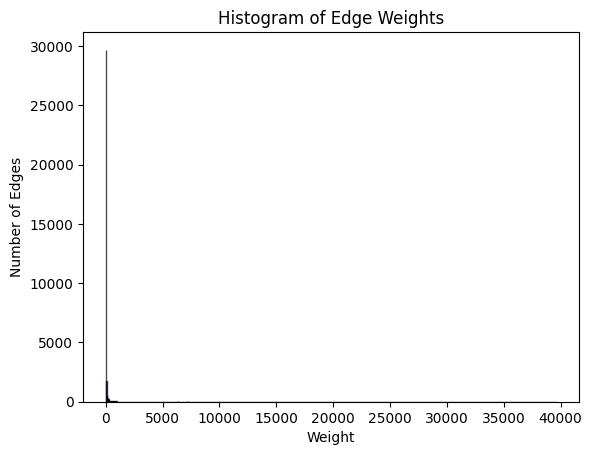

In [197]:
#extract edge weights
hist_data_edge_weights = [SEM_Graph[u][v]['weight'] for u, v in SEM_Graph.edges()]

#determine bin edges based on desired bin width
bin_width = 50
min_edge_weight = min(hist_data_edge_weights)
max_edge_weight = max(hist_data_edge_weights)
bins = np.arange(min_edge_weight, max_edge_weight + bin_width, bin_width)

#plot histogram
plt.hist(hist_data_edge_weights, bins=bins, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Edge Weights')
plt.xlabel('Weight')
plt.ylabel('Number of Edges')
plt.show()

In [218]:
SEM_Graph_clean = focus_edges(G = SEM_Graph, weight_min = 10)

In [219]:
#display a summary of the graph object created
graph_summary_stats(G = SEM_Graph_clean)

----------------------------------------
##### Graph Summary #####
number of nodes: 300
number of edges: 15411

nodes: ['nike', "women's", 'air', 'white', 'available', 'footlocker', 'sneakerscouts', 'adidas', 'lasership', 'work', 'next', 'ad', 'space', 'low', 'snipes_usa', 'snkrs', 'get', 'nikebasketball', 'partnership', 'team', 'release', 'jordan', 'real', 'support', 'friend', 'family', 'kaya_alexander5', 'nikestore', 'sneakeradmirals', 'pair', 'lot', 'wait', 'game', 'jumpman23', 'cnn', 'instagram', 'ebay', 'amazon', 'business', 'max', 'ht', 'dunk', 'adidasoriginals', 'look', 'wearing', 'say', 'drop', 'time', 'vapormax', 'flyknit', 'finishline', 'much', 'people', 'nicekicks', 'snkr_twitr', 'good', 'sport', 'week', 'take', 'black', 'lol', 'think', 'care', 'deal', 'run', 'company', 'win', 'guy', 'see', 'way', 'keep', 'play', 'top', 'going', 'year', 'thank', 'great', 'getting', 'show', 'making', 'want', 'kingjames', 'start', 'blazer', 'red', 'need', 'jersey', 'sneaker', 'day', 'date', 'f

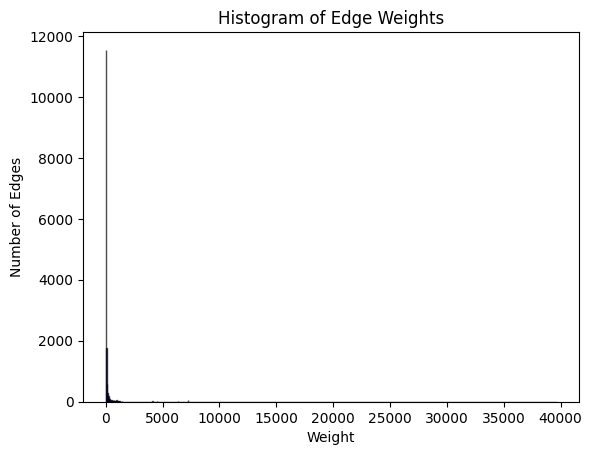

In [210]:
#extract edge weights
hist_data_edge_weights = [SEM_Graph_clean[u][v]['weight'] for u, v in SEM_Graph_clean.edges()]

#plot histogram
plt.hist(hist_data_edge_weights, bins=bins, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Edge Weights')
plt.xlabel('Weight')
plt.ylabel('Number of Edges')
plt.show()

In [211]:
#SEM_Graph_clean.edges(data=True)

## Create Subgraphs for Analysis

In [220]:
##### Shared Sets of Node Intersetions #####

# Define key nodes
key_nodes_all = ['nike', 'lululemon', 'adidas']
key_nodes_nl = ['nike', 'lululemon']
key_nodes_na = ['nike', 'adidas']
key_nodes_al = ['adidas', 'lululemon']

# Find neighbors of the key nodes by themselves
neighbors_sets_n = set(nx.all_neighbors(SEM_Graph_clean, 'nike'))
neighbors_sets_a = set(nx.all_neighbors(SEM_Graph_clean, 'adidas'))
neighbors_sets_l = set(nx.all_neighbors(SEM_Graph_clean, 'lululemon'))

# Find neighbors of the key nodes
neighbors_sets_all = [set(nx.all_neighbors(SEM_Graph_clean, node)) for node in key_nodes_all]
neighbors_sets_nl = [set(nx.all_neighbors(SEM_Graph_clean, node)) for node in key_nodes_nl]
neighbors_sets_na = [set(nx.all_neighbors(SEM_Graph_clean, node)) for node in key_nodes_na]
neighbors_sets_al = [set(nx.all_neighbors(SEM_Graph_clean, node)) for node in key_nodes_al]

# Intersect the sets to get nodes connected to all key nodes
common_neighbors_all = set.intersection(*neighbors_sets_all)

# Intersect the sets to get nodes connected to only 2 key nodes

common_neighbors_nl = set.intersection(*neighbors_sets_nl) - common_neighbors_all - set(key_nodes_al)
common_neighbors_na = set.intersection(*neighbors_sets_na) - common_neighbors_all - set(key_nodes_nl)
common_neighbors_al = set.intersection(*neighbors_sets_al) - common_neighbors_all - set(key_nodes_na)

# Get nodes connected to any one of the key nodes but not all of them
union_neighbors = set.union(*neighbors_sets_all)

# Get nodes connected to only 1 brand
exclusive_neighbors = (union_neighbors - common_neighbors_all
                       - common_neighbors_nl - common_neighbors_na - common_neighbors_al)

# Get nodes connected to each specific brand
exclusive_neighbors_n = neighbors_sets_n - common_neighbors_all - common_neighbors_nl - common_neighbors_na - set(key_nodes_al)
exclusive_neighbors_a = neighbors_sets_a - common_neighbors_all - common_neighbors_na - common_neighbors_nl - set(key_nodes_nl)
exclusive_neighbors_l = neighbors_sets_l - common_neighbors_all - common_neighbors_nl - common_neighbors_al - set(key_nodes_na)


In [221]:
##### Bridging to All Brands Nodes #####
# Create a subgraph
nodes_to_keep = list(common_neighbors_all) + key_nodes_all
SEM_Graph_bridge_3 = focus_edges(G=SEM_Graph_clean, weight_min=125).subgraph(nodes_to_keep)
#display a summary of the subgraph
graph_summary_stats(G = SEM_Graph_bridge_3, title='Bridging to All Brands Nodes')

##### Nike to Adidas Bridges #####
# Create a subgraph
nodes_to_keep = list(common_neighbors_na) + key_nodes_na
SEM_Graph_bridge_na = SEM_Graph_clean.subgraph(nodes_to_keep)
#SEM_Graph_bridge_na = focus_edges(G = SEM_Graph_bridge_na, weight_min = 1000)
#display a summary of the subgraph
graph_summary_stats(G = SEM_Graph_bridge_na, title='Nike to Adidas Bridges')

##### Nike to Lululemon Bridges #####
# Create a subgraph
nodes_to_keep = list(common_neighbors_nl) + key_nodes_nl
SEM_Graph_bridge_nl = SEM_Graph_clean.subgraph(nodes_to_keep)
#display a summary of the subgraph
graph_summary_stats(G = SEM_Graph_bridge_nl, title='Nike to Lululemon Bridges')

##### Adidas to Lululemon Bridges #####
# Create a subgraph
nodes_to_keep = list(common_neighbors_al) + key_nodes_al
SEM_Graph_bridge_al = SEM_Graph_clean.subgraph(nodes_to_keep)
#display a summary of the subgraph
graph_summary_stats(G = SEM_Graph_bridge_al, title='Adidas to Lululemon Bridges')

----------------------------------------
##### Bridging to All Brands Nodes #####
number of nodes: 190
number of edges: 781

nodes: ['nike', 'white', 'available', 'adidas', 'work', 'next', 'ad', 'space', 'low', 'get', 'partnership', 'team', 'real', 'support', 'friend', 'family', 'pair', 'lot', 'wait', 'game', 'jumpman23', 'amazon', 'business', 'look', 'wearing', 'say', 'drop', 'time', 'much', 'people', 'good', 'sport', 'week', 'take', 'black', 'lol', 'think', 'care', 'deal', 'run', 'company', 'win', 'guy', 'see', 'way', 'keep', 'top', 'going', 'year', 'thank', 'great', 'getting', 'show', 'making', 'want', 'start', 'red', 'need', 'day', 'fashion', 'know', 'thanks', 'something', 'trying', 'issue', 'let', 'make', 'sure', 'love', 'buy', 'everyone', 'go', 'shoe', 'part', 'hey', 'cool', 'got', 'brand', 'new', 'customer', 'bought', 'month', 'turn', 'please', 'use', 'package', 'put', 'lululemon', 'happy', "we're", 'giving', 'store', 'running', 'thing', "i'm", 'woman', 'service', 'night', 'gonn

In [222]:
##### Exclusive Nodes: Unique to Only 1 Brand #####

# Create a subgraph
nodes_to_keep_exc = list(exclusive_neighbors) + key_nodes_all
SEM_Graph_exc = SEM_Graph_clean.subgraph(nodes_to_keep_exc)

#display a summary of the subgraph
graph_summary_stats(G = SEM_Graph_exc, title='Exclusive Nodes: Unique to Only 1 Brand')

# Create a subgraph
SEM_Graph_exc_n = SEM_Graph_clean.subgraph(list(exclusive_neighbors_n) + ['nike'])
SEM_Graph_exc_a = SEM_Graph_clean.subgraph(list(exclusive_neighbors_a) + ['adidas'])
SEM_Graph_exc_l = SEM_Graph_clean.subgraph(list(exclusive_neighbors_l) + ['lululemon'])

#filter the graph edges to focus on influential to brands
#SEM_Graph_exc_n = focus_edges(G = SEM_Graph_exc_n, weight_min = 125)
#SEM_Graph_exc_a = focus_edges(G = SEM_Graph_exc_a, weight_min = 125)

#display a summary of the subgraph
graph_summary_stats(G = SEM_Graph_exc_n, title='Exclusive Nodes for Nike')
graph_summary_stats(G = SEM_Graph_exc_a, title='Exclusive Nodes for Adidas')
graph_summary_stats(G = SEM_Graph_exc_l, title='Exclusive Nodes for Lululemon')

----------------------------------------
##### Exclusive Nodes: Unique to Only 1 Brand #####
number of nodes: 43
number of edges: 113

nodes: ['ronwyden', 'se', 'purple', 'donovan', 'enduyghurforcedlabor', 'snipes_usa', 'thee', 'mitchell', 'cnn', 'ene', 'nike', 'brilliant', 'xboxsweepstakes', 'sneakerscouts', 'nikenyc', 'lebron', 'flyknit', 'knight', 'celtic', 'phil', 'lululemon', 'blazer', 'adidasfballus', 'austinekeler', 'yardrunner', 'nba_newyork', 'centre', 'scctradingcards', 'adidas', 'max', 'modern', 'forced', 'kanter', 'theestallion', 'virgil', 'hyperkin', 'heartbroken', 'vapormax', 'slavery', "abloh's", 'impossibleisnothing', 'graduation', 'maybes']

neighbors of adidas: ['nike', 'adidasfballus', 'impossibleisnothing', 'donovan', 'mitchell', 'austinekeler', 'xboxsweepstakes', 'hyperkin', 'maybes']
neighbors of nike: ['sneakerscouts', 'adidas', 'cnn', 'max', 'snipes_usa', 'vapormax', 'flyknit', 'blazer', 'se', 'nikenyc', 'forced', 'phil', 'knight', 'lebron', 'purple', 'theestall

## Plot All the Graphs

In [246]:
#plot the baseline graph
plot_graph(G = SEM_Graph_clean, file_path='04_01_semantic_network', use_edge_weight=False, plot_size='large')

![picture](https://drive.google.com/uc?id=13Gw10LpnQ_te6xysy4wz82xzzZ4TEzAq)

In [240]:
#plot the graph
plot_graph(G = SEM_Graph_bridge_3, file_path='05_01_semantic_network_bridge_all_3', use_edge_weight=False, plot_size='medium')

#plot the graph
plot_graph(G = SEM_Graph_bridge_na, file_path='05_02_semantic_network_bridge_nike_adidas', use_edge_weight=False, plot_size='small')

#plot the graph
plot_graph(G = SEM_Graph_bridge_nl, file_path='05_03_semantic_network_bridge_nike_lululemon', use_edge_weight=False, plot_size='small')

#plot the graph
plot_graph(G = SEM_Graph_bridge_al, file_path='05_04_semantic_network_bridge_adidas_lululemon', use_edge_weight=False, plot_size='small')

In [241]:
#plot the exclusive node graph
plot_graph(G = SEM_Graph_exc, file_path='06_01_semantic_network_exclusive', use_edge_weight=False, plot_size='small')

#plot the graph
plot_graph(G = SEM_Graph_exc_n, file_path='06_02_semantic_network_exclusive_to_nike', use_edge_weight=False, plot_size='small')

#plot the graph
plot_graph(G = SEM_Graph_exc_a, file_path='06_03_semantic_network_exclusive_to_adidas', use_edge_weight=False, plot_size='small')

#plot the graph
plot_graph(G = SEM_Graph_exc_l, file_path='06_04_semantic_network_exclusive_to_lulu', use_edge_weight=False, plot_size='small')

# 5.&nbsp;Graph with Pyvis


In [ ]:
#https://pyvis.readthedocs.io/en/latest/tutorial.html
# create a network model in pyviz
nt = Network(height="600px", width="100%", directed=True, notebook=True, layout='force_atlas_2based', cdn_resources='remote')
# populates the nodes and edges data structures
nt.from_nx(MEN_Graph)
nt.show_buttons(filter_=['physics'])
nt.show('nx.html')
from IPython.core.display import display, HTML
display(HTML('nx.html'))

# 6.&nbsp;Analysis of Graphs

Some key questions are answered in this section. Images used in this section can be accessed [here](https://drive.google.com/drive/folders/135fpvuqno7pHOgTLovqDG-mJw8o-CXW6?usp=drive_link).

## **[1] Mention Networks: Who are the Most Central Users?**

In looking at your directed, valued network of mentions, what users are most central for each brand? Inspect at least the top 10 most central for each brand. Who are they? Why do you think they're so engaged with your brand on Twitter?

From an advertising/marketing perspective, these are our loyal brand ambassadors. A good social media manager should know who these people are and give them preferential treatment, such as sending them swag, sending them early access to new products/content, and generally engaging with them on the platform to show reciprocity in the relationship.


![picture](https://drive.google.com/uc?id=13BLksm_2IGi0FKJ6ucZ38Y7658jcVUfP)

After reviewing the mention network and using a sub-graph to better focus in on the unique users related to teach brand, I selected the following users as an example of central user to each brand.

1. [Solefed](https://twitter.com/solefed) (Nike): This user focuses on sneakers, restocks, releases, and deals. He does a lot of tweeting about the nike brand and appears to be an influencer, on a moderate scale.
2. [KatGraham](https://twitter.com/KatGraham) (Adidas): Kate Graham appears to be a celebrity that talks about the Adidas brand alot.
3. [GolfDigest](https://twitter.com/GolfDigest) (Lululemon): Golf Digest is a magazine an is one the largest conversation leaders about Lululemon. They likely have a marketing agreement with the brand.

**Central Users to Nike**

<img src='https://drive.google.com/uc?id=139p5zvvHEDcwOZaGbXHEpzAbJZTCN66D' width="auto" height="600">

**Central Users to Adidas**

<img src='https://drive.google.com/uc?id=135qEnloppB7gRdK471_E7vEFKHF5sAOw' width="auto" height="600">

**Central Users to Lululemon**

<img src='https://drive.google.com/uc?id=139kS3-15Tg5XXggZyYb9sucoU-K6GfHC' width="auto" height="600">

## **[2] Mention Networks: Who are the Most Important Bridgers?**

Some users will mention multiple (or all three) brands. Who are those people? If bridge users (bridgers) exist, who are they? Why are they interested in this product so much? From an advertising/marketing perspective, these are people who are "pro users" of your category, and their hyper interest is something that you can use to engage with them, that is, they'll always be interested in your new product/services before others are.





![picture](https://drive.google.com/uc?id=13Bjjbjai2G_tuNEVqLtZO49oiSL9Xo3q)

While limited, I decided to focus on the 3 user accounts that bridge between all 3 brands have a significant amount of mentions. These brands are highlighted below.

1. [Wwd](https://twitter.com/wwd): An account focused on fashion, beauty, and business. Their scope of conversation includes Nike, Adidas, and Lululemon. Given their 2.7M follwes, they can be considered a media outlet that is working to set trends.
2. [Uniwatch](https://twitter.com/UniWatch): An influencer with 138.8K followers. They focusing on athletic asthetics, so they would be a good point of contact to engage on a regular basis.
3. [deezefi](https://twitter.com/DeeZeFi): An influencer that appears to be from the definance space. It would be worth investigating why your brand is a topic of conversation related to blockchain and other defi topics.

**Bridging to All Brands**

<img src='https://drive.google.com/uc?id=13Q9a4Wdqh7aT679QMwinZRV8nJMN-ovU' width="auto" height="600">

**Bridging Between Nike & Adidas**

<img src='https://drive.google.com/uc?id=13QDgBJUAeJn8IdLGGbYe1A9E2PAe7mHr' width="auto" height="600">

**Bridging Between Nike & Lululemon**

<img src='https://drive.google.com/uc?id=13SODt329hK42Bzfu3HwjK5Wk-2Zg4YHX' width="auto" height="600">

**Bridging Between Adidas & Lululemon**

<img src='https://drive.google.com/uc?id=13U-MnOw1j6iapdhGHIUyS7mrOUofm-bE' width="auto" height="600">

## **[3] Semantic Networks: What are Key Clusters of Activity?**

Look at the word clusters. Interpret them. Identify the key clusters of activity. What's going on in each cluster?

![picture](https://drive.google.com/uc?id=13E70-AskbctaNo-29oUveQUlPkUpGA8h)

While there are many cluster of actvity, I found the following five to be most interesting and having the tightest clustering.

1. Jordan's and Lebron James Shoe Releases
2. Xbox Promotion Where You Can Win Exclusive Gear
3. Booking Airline Tickets to China
4. Negative Sentiment About Forced Labor Practices
5. Postive Sentiment and General Lust for Athletic Shoes

## **[4] Semantic Networks: What Word Clusters Does Each Brand Own?**

What attributes (words, or cluster of words) does each brand uniquely own? That is, what attributes are uniquely linked to each brand? From a marketing perspective, the most central nodes are the attributes that each brand most "owns." These are implicit to the consumer, and therefore our strengths. Practically, this means that the brand doesn't need to do work advertising/marketing these perceptions, instead it should focus on reinforcing things that aren't as central, or missing from this semantic network completely.

![picture](https://drive.google.com/uc?id=13DAxHMQ-DKMcHhKW3WFoN5uziYtO6PF_)

The Nike Brand had very strong clusters of words that they owned. These included:
1. The Launch of New Lebron James Shoe that is Praised as Brilliant and Innovative
2. Trademarked and Brand Specific Shoe and Clothing Technologies
3. A Propotion to Win Baseball Trading Cards

**Central Users to Nike**

<img src='https://drive.google.com/uc?id=13i7j6P6jlKMOKv4Ui4U0ba8L6ob8kf9c' width="auto" height="600" border="solid 2px red">

**Central Users to Adidas**

<img src='https://drive.google.com/uc?id=13hpMLQeul5vJKV92VD7IppXwLGyQhFRb' width="auto" height="600">

**Central Users to Lululemon**

<img src='https://drive.google.com/uc?id=13hVts3ROCd1NCNjS12fqI2pmVIRQlJjG' width="auto" height="600">

## **[5] Semantic Networks: What are the Most Important Bridging Words?**

Brands will likely share some key attributes (words). If so, what are they? What commonalities do brands have with each other? These commonalities can be thought of as product differentiation things to avoid. That is, we'd never create advertising or marketing materials that reflect non-unique attributes about our products. Knowing that we share things with our competitors also can tell us how we better need to differentiate our products.

Across the 3 brands, the most common bridging words focused on:
1. Positive sentiment words
2. Temporal (time) related words
3. Store and shopping words
4. Customer service related words

Overall, the shared words across the 3 brands were fairly generic.

When looking at Nike and Adidas, they shared words related to shoes and types of sports. In general, Lululemon was talked about much less on Twitter and seemed have fewer commonalities with Adidas and Nike.

**Bridging to All Brands**

<img src='https://drive.google.com/uc?id=13qG6HLi7SL3Umai4puTYoFctFXwJBAEg' width="auto" height="600">

**Bridging Between Nike & Adidas**

<img src='https://drive.google.com/uc?id=13psQ6W9k96m6FSn48rMt1zX_jIuvzJal' width="auto" height="600">

**Bridging Between Nike & Lululemon**

<img src='https://drive.google.com/uc?id=13pon8wxphlg9-eE61waPCaLqZ9aDJjN7' width="auto" height="600">

**Bridging Between Adidas & Lululemon**

<img src='https://drive.google.com/uc?id=13oSpnXpmzZJ7AXfWMIH_FbJekTs9vXUu' width="auto" height="600">